In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from collections import Counter

In [2]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

In [3]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):
    
    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [4]:
def get_cluster_dfs(df, cluster):
    return[df[cluster == i] for i in np.unique(cluster)]

In [5]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [201]:
aggr = aggregate_by_label(df, 'genre', 0)

In [202]:
tfidf = TfidfVectorizer(
    #stop_words=get_stop_words('de'),
    max_features=250)

X = tfidf.fit_transform(aggr.text)
X = X.todense()

In [203]:
Xr = UMAP(n_components=2, n_neighbors=20).fit_transform(X)
#Xr = PCA(n_components=2).fit_transform(X)

In [204]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

In [205]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0            Drama
 1           Comedy
 6           Horror
 11     Documentary
 13        Thriller
 18          Action
 30          Family
 64           Crime
 92       Adventure
 108        Western
 112         Sci-Fi
 124        Romance
 132        Fantasy
 161            War
 183      Animation
 287          Music
 329        Musical
 338      Biography
 Name: label, dtype: object,
 18)

In [206]:
from sklearn.mixture import GaussianMixture

clu = GaussianMixture(n_components=n_single_labels)
Xpca = UMAP(n_components=50, n_neighbors=3).fit_transform(X)

cluster = clu.fit_predict(Xpca)
probs = clu.predict_proba(Xpca)

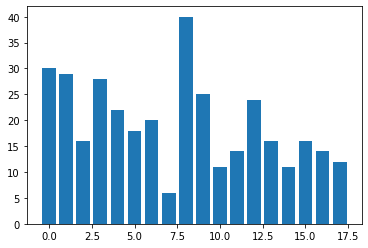

In [207]:
cluster_counter = Counter(cluster)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [208]:
probs.argmax(axis=1)

array([ 8,  0,  0,  8,  8,  0,  6,  5, 11, 15,  9,  4,  5,  5, 15,  2, 10,
       12, 15,  5,  3,  1,  1, 10, 15, 11,  6, 16, 12,  5, 17,  9, 13,  1,
       10,  2,  3, 12, 15, 13,  6, 15,  6, 13, 10, 17, 16, 15,  9,  5,  9,
        1,  8,  8,  5,  5,  9,  3,  6, 11, 12,  1,  3,  0,  5,  2,  5, 13,
        5,  3,  9,  1,  1, 17,  6,  0,  6,  4,  6,  8,  2,  1,  0,  8,  9,
        8, 16,  8, 16,  1, 11, 12, 12, 14,  3,  0, 15,  5, 13, 17, 11,  5,
       16, 10,  0,  0,  2, 16, 10,  8,  8, 13,  1,  2,  4, 12,  2,  4,  5,
       11,  4, 11,  3,  5,  8,  4,  8,  8, 12, 16,  3, 13,  8, 16, 17,  0,
        0, 15, 17, 12, 12,  6, 11, 10,  1, 11, 10,  3,  8,  9,  8,  1,  8,
        6, 15,  0,  1,  5,  0,  8,  1, 13,  5,  1, 16,  8,  0,  8, 12,  0,
        6, 15, 11, 14, 12, 13,  3, 10,  1,  9,  8,  3,  4,  9, 15,  1,  0,
       12,  4,  9, 12,  4, 11, 11, 14, 15, 15, 13,  0,  8, 16,  9, 13, 14,
        3,  1,  1,  4,  6, 16, 14,  6,  9,  2,  8, 11,  4,  6,  6, 10,  1,
        4, 15,  1,  3, 11

In [209]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(cluster)))


fig.show()

In [210]:
dfs = get_cluster_dfs(aggr, cluster)

In [211]:
for cluster_df in dfs:
    print(cluster_df.label)
    print(f'Total number of movies in cluster => {cluster_df.n_texts.sum()}')
    print(f'Total number of tokens in cluster => {cluster_df.n_tokens.sum()}')
    print('#'*60)

1                         Comedy
2                   Comedy,Drama
5                 Comedy,Romance
63                 Comedy,Family
75                   Drama,Music
82           Comedy,Drama,Family
95                   Drama,Sport
104               Comedy,Fantasy
105        Comedy,Horror,Romance
135                Comedy,Sci-Fi
136                 Comedy,Music
155             Animation,Comedy
158           Action,Drama,Sport
166       Adventure,Comedy,Crime
169        Comedy,Family,Romance
186         Drama,Fantasy,Sci-Fi
198         Comedy,Music,Musical
276        Adventure,Drama,Sport
278      Biography,Drama,Fantasy
285       Mystery,Romance,Sci-Fi
287                        Music
293          Drama,Fantasy,Music
311          Crime,Drama,Fantasy
326    Adventure,Biography,Crime
336         Drama,Music,Thriller
340                 Thriller,War
343       Comedy,Romance,Western
344       Comedy,Musical,Romance
348        Comedy,Romance,Sci-Fi
351    Action,Comedy,Documentary
Name: labe